# RAPOOC Algorithm

In [1]:
%matplotlib inline
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.metrics import consensus_score
import multiprocessing as mp
import pandas as pd
import glob as glob
from functools import reduce

In [590]:
class PositiveNegativeCorrelation(object):
    def __init__(self, x, y, J):
        self._x = x
        self._y = y
        self._J = J
        self._x_mean = np.mean(x)
        self._y_mean = np.mean(y)
        self._H_pos = None
        self._H_neg = None
 
    @property
    def H_pos(self):
        if self._H_pos is None:
            # print("Computing H positive...")
            self._H_pos = self._compute_H_pos()
            # print("H positive value: " + str(self._H_pos))
        return self._H_pos

    @property
    def H_neg(self):
        if self._H_neg is None:
            # print("Computing H negative...")
            self._H_neg = self._compute_H_neg()
            # print("H negative value: " + str(self._H_neg))
        return self._H_neg

    def _compute_H_pos(self):
        H_pos = 0
        for j in range(self._J):
            aux = (((self._x[j] - self._x_mean) -
                    (self._y[j] - self._y_mean))/2.0)**2
            H_pos += aux
        H_pos *= 1.0/math.fabs(self._J)
        H_pos = 1 - H_pos
        return H_pos

    def _compute_H_neg(self):
        H_neg = 0
        for j in range(self._J):
            aux = (((self._x[j] - self._x_mean) +
                    (self._y[j] - self._y_mean))/2.0)**2
            H_neg += aux
        H_neg *= 1.0/math.fabs(self._J)
        H_neg = 1 - H_neg
        return H_neg

In [807]:
class PairBasedCoherence(object):
    def __init__(self, X):
        self._X = np.array(X)
        self._I, self._J = X.shape
        self._HP = None

    @property
    def HP(self):
        if self._HP is None and self._J>1:
            # print("Calculating Pair based coherence..")
            self._HP = self._compute_HP_()
            # print("Paired based coherence value: " + str(self._HP))
            return self._HP
        else: 
            return 0

    def _compute_HP_(self):
        HP = 0
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i==j): 
                    break
                x = self._X[i]
                y = self._X[j]
                correlation = PositiveNegativeCorrelation(x, y,self._J)
                H0 = correlation.H_pos
                # H0 = max(correlation.H_pos,correlation.H_neg)
                HP += H0
        HP *= math.fabs(2.0)/(math.fabs(self._I)*(math.fabs(self._I)-1)) # if self._I > 1 else 0
        
        return HP

In [808]:
%%latex
Define H for a new term 'z' in X
$$
H_{1}(I,J,X,z) =H_{0}(I,J,X) \cdot \frac{(I-1)}{(I+1)} + \frac{|2|}{(I)(I+1)} \cdot \sum_{x \epsilon X} {h(x,z,J)}
$$

<IPython.core.display.Latex object>

In [880]:
data = pd.read_csv('TestData/SimulatedDataCoherence/HighCoherenceMix.csv',header=None)
data = (data - 0.5) * 2.0

In [881]:
PairBasedCoherence(data).HP

0.74376732981342508

In [882]:

class BisectingClusterer(object):
    def __init__(self, data):
        if data is not None:
            self._data = np.array(data)
            self._I, self._J = self._data.shape
        else:
            print("Empty data")
    
    @property
    def centroids(self):
        return self._centroids

    def fit(self):
        self._centroids = self._compute_centroids_()
        bisecting_indices = self._bisect_clusters_(self._centroids)
        return bisecting_indices
    
    def _compute_centroids_(self):
        max_correlation = 0
        centroids = [0,0]
        for i in range(self._I):
            for j in range(i+1, self._I):
                if (i == j):
                    break
                correlation = PositiveNegativeCorrelation(self._data[i],
                                                          self._data[j],
                                                          self._J).H_neg
                if(correlation > max_correlation):
                    max_correlation = correlation
                    centroids[0] = i
                    centroids[1] = j
        return centroids

    def _bisect_clusters_(self, centroids):
        cluster_indices = np.zeros(self._I)
        for i in range(self._I):
            correlation0 = PositiveNegativeCorrelation(
                self._data[centroids[0]], self._data[i],self._J).H_pos
            correlation1 = PositiveNegativeCorrelation(
                self._data[centroids[1]], self._data[i],self._J).H_pos
            if(correlation0 <= correlation1):
                cluster_indices[i] = 1
        return cluster_indices

In [883]:
class Rapooc_test(object):
    def __init__(self, D, k, l, K):
        self._D = np.array(D)
        assert k>0 and l >0, "invalid values, k>0 and l>0"
        self._k = k
        self._l = l
        assert K <= k*l and k>=1, "invalid values, 1<= K <= k*l"
        self._K = K
        self._rho = np.ones(D.shape[0])
        self._gamma = np.ones(D.shape[1])
        self._M, self._N = self._D.shape
        self._rows_h_score = None
        self._cols_h_score = None
        self._cluster_H_values = np.array([ [0.0] * (int(self._k) + 1)  
                                    for _ in range(int(self._l + 1))])
    
            
    @property
    def rho(self):
        return self._rho
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def bicluster_h_values(self):
        assert not self._cluster_H_values is None, "H values have not yet been calculated"
        return self._cluster_H_values

    def initialize(self):
        i = 1
        j = 1
        while (i < self._k or j < self._l):
            if i < self._k:
                i += 1
                alpha = self._argmin_H_(self._rho, self._gamma,'row')
                self._bisect_partitions_(self._D[np.where(self._rho ==alpha)], self._rho, alpha, i,'row')
            if j < self._l:
                j += 1
                beta = self._argmin_H_(self._rho,self._gamma, 'column')
                self._bisect_partitions_((self._D.T)[np.where(self._gamma==beta)], self._gamma, beta, j,'column')   

    def _argmin_H_(self, row_co_cluster, col_co_cluster,option='row'):
        if (option=='row'):
            data = self._D
        else:
            data = self._D.T
        h_min = math.inf
        min_cocluster = 1
        map_array = np.int64(row_co_cluster if option == 'row' else col_co_cluster)
        max_index_in_map = np.max(map_array) + 1
        for i in range(1,max_index_in_map):
            if (list(map_array).count(i) < 2):
                pass
            else:
                coherence = PairBasedCoherence(
                    data[np.where((row_co_cluster if option == 'row' else col_co_cluster) == i)]).HP 
                if (coherence <= h_min):
                    h_min = coherence
                    min_cocluster = i
        return min_cocluster

    def _bisect_partitions_ (self, data, mapping_array, cluster_to_replace, new_cluster_index,option='row'):
        clusterer = BisectingClusterer(data)
        bisected_map = clusterer.fit()
        bisected_map_index = 0
        for i in range(0,len(mapping_array)):
            if ((self._rho if option == 'row' else self._gamma)[i] == cluster_to_replace):
                if (bisected_map[bisected_map_index] == 1.0):
                    (self._rho if option == 'row' else self._gamma)[i] = new_cluster_index
                bisected_map_index += 1
    
    def _compute_objective_function_(self):
        

        for i in range(1,int(max(self._rho) + 1)):
            for j in range (1, int(max(self._gamma) + 1)):
                # print("% debug % cluster i " + str(i) + " cluster j " + str(j))
                coherence = PairBasedCoherence(self._D[np.ix_(np.where(self._rho == i)[0],
                                                              np.where(self._gamma == j)[0])]).HP
                
                # print(self._D[np.ix_(np.where(self._rho == i)[0],
                                                              # np.where(self._gamma == j)[0])])
                self._cluster_H_values[i][j] = coherence
            
        print(self._cluster_H_values)
        
        h_values_1d = self._cluster_H_values.flatten()
        
        idx_1d = h_values_1d.argsort()[-self._K:]
        
        x_idx, y_idx = np.unravel_index(idx_1d, self._cluster_H_values.shape)
        
        acc=0
        for x, y, in zip(x_idx, y_idx):
            print("% debug % x_idx " + str(x) +" y_idx " +str(y) + " H value "+ str(self._cluster_H_values[x][y]))
            acc += self._cluster_H_values[x][y]
        
        print("%debug % FO value " + str(acc/self._K) + " accumulator "+str(acc))
        return (acc/(self._K))
    
    def core_co_clustering(self):
        
        n_iterations = 0
        n_repetitions = 0
        of_last_value = 0
        best_iter = 0
        best_OF = 0
        best_rows = self._rho
        best_columns = self._gamma
        while(n_iterations < (self._k * self._l) and n_repetitions < int((self._k * self._l) * 0.3)):
            
            if(n_iterations == 0): 
                objective_function = 0 
            else: 
                objective_function=self._compute_objective_function_() 
            temp_rows = self._update_maps_(option = 'rows')
            temp_columns = self._update_maps_(option = 'columns')
            
            if (objective_function > best_OF):
                best_iter = n_iterations
                best_OF = objective_function
                best_rows = temp_rows
                best_columns = temp_columns
            # break conditions
            if (math.fabs(1 - objective_function) < 0.2):
                break
            """ 
            if(math.fabs(objective_function - of_last_value) > 0.001):
                of_last_value = objective_function
                n_repetitions = 0
            else:
                n_repetitions += 1
            """     
            n_iterations += 1
        
        self._rho = best_rows
        self._gamma = best_columns
        print("Finishing core-coclustering")
        print("Number of iterations " + str(n_iterations))
        print("Objective function " + str(math.fabs(best_OF)) + " at iter " +str(best_iter))
        print("Number of repetitions " + str(n_repetitions))
        '''
        for i in range(1,int(max(self._rho) + 1)):
            for j in range (1, int(max(self._gamma) + 1)):
                print("% debug % cluster i " + str(i) + " cluster j " + str(j))
                print(self._D[np.ix_(np.where(self._rho == i)[0],
                                                              np.where(self._gamma == j)[0])])
        '''
    
        # ax = sns.tsplot(data= self._D[np.ix_(np.where(self._rho == 1)[0],np.where(self._gamma == 2)[0])] 
                                # , err_style="unit_traces")
    def _update_maps_(self,option = 'rows'):
        
        if(option == 'rows'):
            mapping_array = self._rho
            data = self._D
        elif (option == 'columns'):
            mapping_array = self._gamma
            data = self._D.T
            
        for i in range(0,len(data)):
            self._compute_arg_max_(data,mapping_array,i)
            
        return np.copy(mapping_array)
    
    def _compute_arg_max_(self,data,mapping_array,index):
        
        actual_coherence = 0
        previous_cluster = mapping_array[index]
        if (list(mapping_array).count(previous_cluster) <= 2):
            return
        prev_coherence = PairBasedCoherence(data[np.where(mapping_array == previous_cluster)]).HP
        
        mapping_array[index] = 0
        
        local_coherence = PairBasedCoherence(data[np.where(mapping_array == previous_cluster)]).HP
        
        if (prev_coherence >= local_coherence):
            mapping_array[index] = previous_cluster
            actual_coherence = prev_coherence
        else:
            actual_coherence = local_coherence
            
        best_cluster,best_coherence = self._iter_maps_(data, mapping_array, index, previous_cluster)
        
        if (best_coherence > local_coherence):
            mapping_array[index] = best_cluster
    
    def _iter_maps_(self, data, mapping_array, index, previous_cluster):
        
        best_coherence = 0
        best_cluster = 0
        
        for actual_cluster in range(1,int(max(mapping_array))+1):
            if actual_cluster == previous_cluster:
                pass
            else:
                mapping_array[index] = actual_cluster
                coherence = PairBasedCoherence(data[np.where(mapping_array == actual_cluster)]).HP
                if(coherence >= best_coherence):
                    best_coherence = coherence
                    best_cluster = actual_cluster
                    # print("% debug %" + str(coherence))
                    
        return best_cluster, best_coherence

In [884]:
rapooc = Rapooc_test(data,2,2,2)

In [885]:
rapooc.initialize()

In [886]:
rapooc.rho

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

In [887]:
rapooc.gamma

array([ 1.,  1.,  1.,  2.,  2.,  1.,  1.])

In [888]:
rapooc.core_co_clustering()

[[ 0.          0.          0.        ]
 [ 0.          0.99072752  0.99394725]
 [ 0.          0.99996736  0.99994552]]
% debug % x_idx 2 y_idx 2 H value 0.999945521153
% debug % x_idx 2 y_idx 1 H value 0.999967362739
%debug % FO value 0.999956441946 accumulator 1.99991288389
Finishing core-coclustering
Number of iterations 1
Objective function 0.9999564419458579 at iter 1
Number of repetitions 0


/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


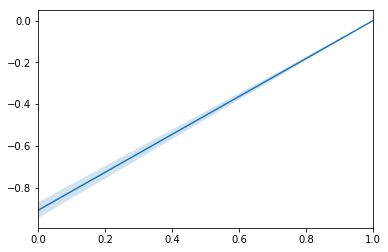

In [894]:
sns.tsplot(data= rapooc._D[np.ix_(np.where(rapooc._rho == 2)[0],np.where(rapooc._gamma == 2)[0])])

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


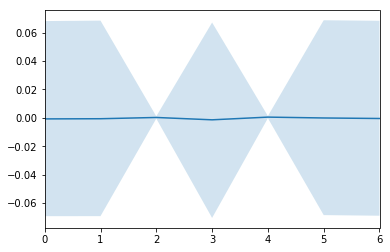

In [895]:
sns.tsplot(np.array(data))

In [891]:
rapooc.gamma

array([ 1.,  1.,  1.,  2.,  2.,  1.,  1.])

In [892]:
rapooc.rho

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

# Testing

In [744]:
import seaborn as sns

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


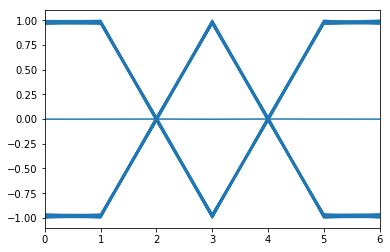

In [878]:
ax = sns.tsplot(data=np.array(data), err_style="unit_traces")

In [746]:
data.head()

,0,1,2,3,4,5,6
0,-0.328500,-0.824558,-0.03132,0.40778,-0.42616,-0.365000,-0.42370
1,-0.362280,-0.734220,0.45380,0.09060,-0.03060,-0.746820,-0.03512
2,-0.702940,-0.737160,0.39322,0.22716,-0.46024,-0.851982,-0.03118
3,-0.721220,-0.967224,-0.22162,0.85422,0.15794,-0.997235,-0.01522
4,-0.829484,-0.614420,-0.19632,0.60592,0.20586,-0.991202,-0.56098


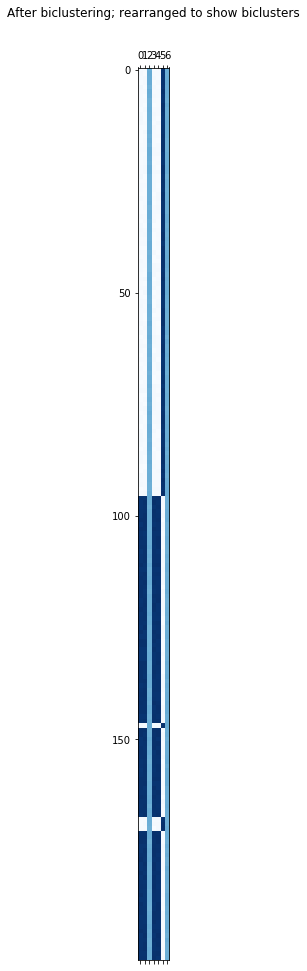

In [896]:
fit_data = np.array(data)[np.argsort(rapooc.rho)]
fit_data = fit_data[:, np.argsort(rapooc.gamma)]
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

Text(0.5,1.05,'Original dataset')

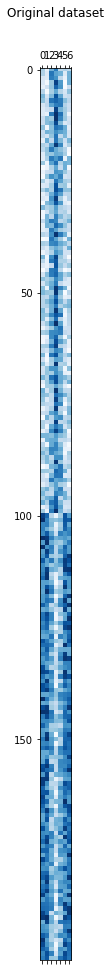

In [748]:
plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")

In [749]:
from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.preprocessing import MinMaxScaler
test_data, rows, columns = make_biclusters(
    shape=(100, 7), n_clusters=5, noise=5,
    shuffle=False, random_state=0)

Text(0.5,1.05,'Shuffled dataset')

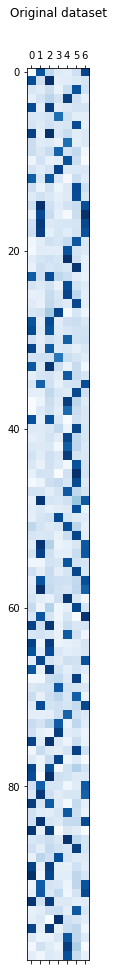

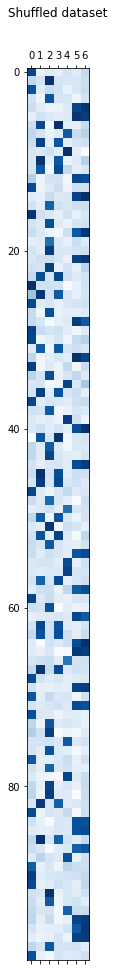

In [879]:
plt.matshow(test_data, cmap=plt.cm.Blues)
plt.title("Original dataset")

scaler = MinMaxScaler()
scaler.fit(test_data)
test_data = scaler.transform(test_data)

test_data, row_idx, col_idx = sg._shuffle(test_data, random_state=0)
plt.matshow(test_data, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


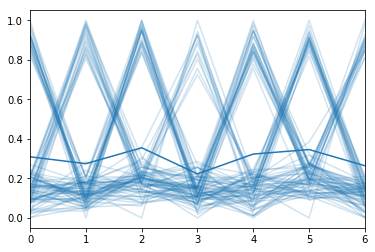

In [766]:
ax = sns.tsplot(data=np.array(test_data), err_style="unit_traces")

In [767]:
rapooc_test = Rapooc_test(test_data,5,5,5)
rapooc_test.initialize()

In [768]:
rapooc_test.gamma

array([ 1.,  3.,  1.,  4.,  5.,  2.,  3.])

In [769]:
rapooc_test.rho

array([ 1.,  4.,  3.,  3.,  3.,  4.,  2.,  3.,  3.,  4.,  3.,  4.,  4.,
        2.,  2.,  1.,  1.,  1.,  1.,  2.,  3.,  3.,  2.,  4.,  3.,  3.,
        2.,  4.,  3.,  3.,  3.,  3.,  4.,  4.,  3.,  1.,  2.,  3.,  3.,
        4.,  2.,  3.,  3.,  3.,  2.,  3.,  2.,  3.,  1.,  2.,  4.,  3.,
        3.,  1.,  1.,  3.,  2.,  1.,  1.,  3.,  2.,  1.,  3.,  3.,  3.,
        4.,  1.,  4.,  2.,  4.,  2.,  1.,  3.,  4.,  4.,  4.,  2.,  4.,
        3.,  4.,  5.,  1.,  2.,  3.,  1.,  3.,  3.,  2.,  4.,  4.,  2.,
        5.,  5.,  4.,  2.,  4.,  3.,  3.,  3.,  3.])

In [770]:
rapooc_test.core_co_clustering()

[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.99914268  1.          0.99936525  1.          1.        ]
 [ 0.          0.99918455  1.          0.99931345  1.          1.        ]
 [ 0.          0.99945972  1.          0.99920655  1.          1.        ]
 [ 0.          0.99854242  1.          0.99871287  1.          1.        ]
 [ 0.          0.99907916  1.          0.99895451  1.          1.        ]]
% debug % x_idx, y_idx 1.0
% debug % x_idx, y_idx 1.0
% debug % x_idx, y_idx 1.0
% debug % x_idx, y_idx 1.0
% debug % x_idx, y_idx 1.0
%debug % FO value 1.0 accumulator 5.0
Finishing core-coclustering
Number of iterations 1
Objective function 1.0 at iter 1
Number of repetitions 1
% debug % cluster i 1 cluster j 1
[[ 0.18316434  0.20868347]
 [ 0.85019897  0.97591334]
 [ 0.05752669  0.17452294]]
% debug % cluster i 1 cluster j 2
[[ 0.16734024]
 [ 0.24159874]
 [ 0.27547041]]
% debug % cluster i 1 cluster j 3
[[ 0.20623117  0.10904945]
 [ 0.141647

sns.tsplot(data= rapooc_test._D[np.ix_(np.where(rapooc_test._rho == 2)[0],np.where(rapooc_test._gamma == 2)[0])])

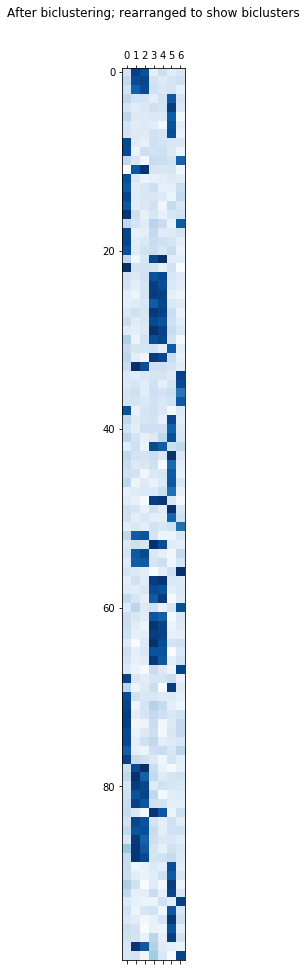

In [757]:
fit_data = np.array(test_data)[np.argsort(rapooc_test.rho)]
fit_data = fit_data[:, np.argsort(rapooc_test.gamma)]
plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()

In [473]:
model_rows = list()
for i in range(1,int(max(rapooc_test.rho)) + 1):
    r = list()
    for j in range(0,len(rapooc_test.rho)):
        r.append(i==rapooc_test.rho[j])
    model_rows.append(r)

In [474]:
model_columns = list()
for i in range(1,int(max(rapooc_test.gamma)) + 1):
    r = list()
    for j in range(0,len(rapooc_test.gamma)):
        r.append(i==rapooc_test.gamma[j])
    model_columns.append(r)

model = (np.array(model_rows),np.array(model_columns))

In [735]:
np.array([ [0.0] * (int(3) + 1) for _ in range(int(4 + 1))])

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [ ]:
score

In [477]:
a = np.array([ [0.0] * ((3) + 2)  for _ in range(int(2+ 1))])

In [798]:
class Test:
    def __init__(self):
        self._a = 0
        
    def test_method(self):
        if(self._a == 0):
            print("return")
            return
        print("didn't return")
    

In [799]:
t = Test()

In [800]:
t.test_method()

return
